In [168]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font',**{'family':'sans-serif','sans-serif':['Liberation Sans']})


def getStation(file1, st):
    elev1 = []
    
    with open(file1) as f1:
        l1 = f1.readline()
        l1 = f1.readline()
        
        # Get timestep info
        info = l1.split()
        skip = float(info[3])
        dt = float(info[2]) / skip
        
        l1 = f1.readline()

        for lineno, line in enumerate(f1):
            lines = line.split()
            if lines[0] == str(st):
                x = float(lines[1])
                
                # If dry, set to zero
                if x < -100:
                    x = 0.
                    
                elev1.append(x)

    time = np.arange(len(elev1))*dt*skip/86400.

    return time, np.array(elev1)

def getGauge(root, gauges, gauge, dt=3600, offset=12):
    elev = []
    file = root + '/' + gauges[gauge][0] + ".csv"
    
    with open(file) as f1:
        l1 = f1.readline()
        for lineno, line in enumerate(f1):
            lines = line.split(',')
            if lines[-1] == '\"-\"\n':
                #break
                if lines[-2] != '\"-\"':
                    l = lines[-2][1:-2]
                #print(l)
                elev.append(float(l))
            else:

                elev.append(float(lines[-1][1:-2]))

    of = int(offset*60*60/dt)
    elev = elev[of:]
    time = np.arange(len(elev))*dt/86400.
    return time, elev


class Storm():
    def __init__(self, root, files, gauges):
        self.root = root
        self.files = files
        self.gauges = gauges
        
    def plot(self, station, *args, plot_gauge=True, dt=3600, offset=12):
        self.f = plt.figure()
        if args:
            keys = args
        else:
            keys = self.files.keys()
            
        for key in keys:
            time, elev = getStation(self.root + '/' + key, station)
            #data[key] = (time, elev)
            plt.plot(time, elev, label=self.files[key])
            
        # Check of gauge exists
        if station in self.gauges:
            plt.title(self.gauges[station][1])
            
        # If we have gauge data, plot it too
        if plot_gauge:
            try:
                time, elev = getGauge(self.root, self.gauges, station, dt=dt, offset=offset)
            except:
                pass
            else:
                plt.plot(time, elev, '--', label='Gauge data')
            
        plt.legend()
        plt.xlabel('time (days)', fontsize=15)
        plt.ylabel('Surface elevation (m)', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.show()
    
    def save(self, name):
        self.f.savefig(name, dpi=300)
        
    def export(self, station):
        for key in self.files.keys():
            time, elev = getStation(self.root + '/' + key, station)
            np.savetxt('%s/%s_%s.csv' % (self.root, key, self.gauges[station][0]), np.vstack((time,elev)).T)

## List of gauges for different datasets
Format:

    { n : (csv_name, plot_name) }
    
where

    n = gauge number
    csv_name = name of the csv gauge data that was downloaded
    plot_name = name that will be used to label gauge data in the plot

In [165]:
# Cut mesh
gauges1 = {
    2:("pier_21", "Galveston Pier 21"),
    56: ("uss_lexington", "USS Lexington"),
    162: ("south_bird", "South Bird Island"),
    52: ("north_jetty", "Galveston Entrance North Jetty"),
    3: ("pleasure_pier", "Galveston Pleasure Pier"),
    80: ("sss_tx_har_002", "SSS-TX-HAR-002"),
    33: ("port_aransas", "Port Aransas"),
    161: ("bob_hall", "Bob Hall Pier"),
    126: ("lamarque_pump", "La Marque Pump Station"),
    42: ("realitos", "Realitos Peninsula"),
    59: ("viola", "Viola Turning Basin"),
    40: ("baffin_bay", "Baffin Bay"),
    48: ("manchester", "Manchester Houston"),
    4: ("rockport", "Rockport")
}

# Neches
gauges2 = {
    39: ("beaumont_club", "Beaumont Yacht Club"),
    38: ("sabine_north", "Sabine Pass North"),
    24: ("sabine_ras_5", "Sabine RAS 5"),
    37: ("rainbow_bridge", "Rainbow Bridge"),
    40: ("saltwater_barrier", "Salt Water Barrier")
}

## 1. Define station, gauges, root file path, and filenames with labels
Usage: Define a Storm object for a single directory

    storm1 = Storm(directory_name, filenames, gauges)
    
where

    directory_name = string of FULL root folder path (no trailing slash)
    filenames      = dict of format {fort.61 file: plot label}
    gauges         = a dict of gauges defined in the previous cell

In [172]:

ike30m = Storm('/workspace/Ike-30m',
              {"fort.61.full": "30m full",
              "fort.61.2008": "2008 mesh, no advection",
              "fort.61.half": "30m cut, reduced manning's n",
               "fort.61.noadv": "30m cut, no advection",
               "fort.61.adv": "30m cut",
              "fort.61.v3": "30m cut v3",
              "fort.61.v4": "30m cut v4",
               "fort.61.v5": "30m cut, 2008 manning's n",
              "fort.61.v5.noadv": "30m cut, 2008 manning's n, no advection"},
              gauges1)

harvey_rain = Storm('/workspace/Harvey-rain',
                   {"fort.61.rain": "DG rain",
                    "fort.61.norain": "DG no rain",
                    "fort.61.adc": "ADCIRC",
                    "fort.61.2008.storm": "2008 mesh",
                    "fort.61.adc.storm": "ADCIRC (no spinup)"},
                   gauges1)
harvey_spinup = Storm('workspace/Harvey-rain/spinup',
                     {"fort.61.2008.spinup": "2008 spinup, LLF flux",
                     "fort.61.dg": "120m spinup, Roe flux",
                      "fort.61.2008.spinup2": "2008 spinup 2",
                     "fort.61.adc": "120m spinup, ADCIRC"},
                     gauges1)
musikal = Storm('workspace/musikal',
               {"fort.61": "Tides only"},
               gauges1)

# Step 2: Plot the data
Usage: use the Storm.plot() method to plot a specified station data, optionally specifying which fort.61 files to plot

    storm1.plot(gauge_num, file1, file2, ..., plot_gauge=False, dt=360)
    
where

    gauge_num = gauge number
    fileN     = name of the fort.61 file to plot. If omitted it will plot all in the dict.
    plot_gauge = whether to plot gauge data or not
    dt         = offset in minutes for gauge data

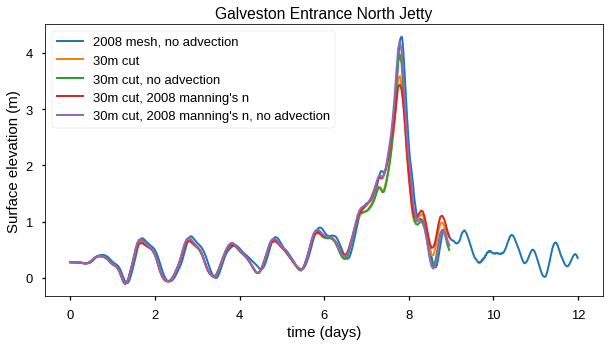

In [160]:
#harvey_rain.plot(33, "fort.61.norain","fort.61.2008.storm",plot_gauge=True)
ike30m.plot(52,"fort.61.2008","fort.61.adv","fort.61.noadv","fort.61.v5","fort.61.v5.noadv",plot_gauge=False,dt=360)
#harvey_spinup.plot(161,"fort.61.2008.spinup2",offset=0)
#musikal.plot(3)

# Step 3: save the plot and/or export fort.61 files to CSV
Usage:

    storm1.save(filepath)       - save the figure in filepath
    storm1.export(station)      - save all fort.61 data as CSV, appending station name and '.csv'
    
   

In [161]:
ike30m.save('../Ike-30m/north_jetty.png')

In [173]:
ike30m.export(48)

In [170]:
pwd

'/workspace/chg'